In [1]:
# Import essential packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import seaborn as sns
import sys

# Import the project utils
sys.path.insert(0, '../utilities/')
import mwc_induction_utils as mwc
import sortseq_utils as sortseq
mwc.set_plotting_style()

colors=sns.color_palette('RdPu', 6)[2:]
colors_alt=sns.color_palette('Blues')
sns.set_palette(colors)

colors_qual=sns.color_palette(
    ['#bf0087', '#e5b600', '#40ac00', '#5233ea', '#bf3800', '#00acac'])

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## The connection between binding energy and fitness

In Laessig *et al* (2004), two simple models are proposed for relating TF binding energy to fitness. In one of these, referred to as a "crater" landscape, gene expression has two primary states that contribute to fitness, an on and off state. In such a fitness landscape, we may consider the fitness to be proportional to the dynamic range, with a fitness peak where dynamic range is maximized. This may be a good model for the Lac system, since LacZYA expression in the absence of lactose is costly, but it is highly desirable in the presence of lactose. Therefore we might consider the dynamic range to be the primary determinant of fitness for transcriptional regulation in the Lac system. The simple repression architecture we have been working with in this paper is a highly simplified version of the Lac regulatory system, but it can serve as a model for considering how TF binding energy affects fitness.

Generally, evolutionary models of binding energy have employed a simplified version of binding in which all mismatches relative to the strongest binding sequence have identical energy penalties. The advantage of such a model is that it can be generalized to situations where neither the wild-type TF binding energy nor the energy matrix are known. However, our highly accurate model for LacI binding affords us the opportunity to examine the unique consequences of specific mutations.

We begin by considering the dynamic range as a function of binding energy.

\begin{equation} 
\mathrm{min} = \frac{1}{1 + \frac{1}{1 + e^{-\Delta \beta \varepsilon_{AI}}} \frac{R}{NNS} e^{-\Delta \beta \varepsilon_R}}
\end{equation}

\begin{equation} 
\mathrm{max} = \frac{1}{1 + \frac{1}{1 + e^{-\Delta \beta \varepsilon_{AI}}\left(\frac{K_A}{K_I}\right)^2} \frac{R}{NNS} e^{-\Delta \beta \varepsilon_R}}
\end{equation}

And then the dynamic range is simply $\mathrm{max} - \mathrm{min}$. This is shown in code below. 

In [2]:
def dynamic_range(Op, R):
    '''
    Returns dynamic range for lac simple repression system.
    
    INPUTS
    ------
    Op: float, repressor-operator binding energy
    R: float, number of repressors per cell
    
    OUTPUTS
    -------
    Dynamic range
    '''
    # Define variables for LacI
    e_AI = 4.5 # Free energy difference between active and inactive state; k_BT units
    K_A = 141 # Inducer dissociation constant for active repressor; uM units
    K_I = 0.56 # Inducer dissociation constant for inactive repressor; uM units
    NNS = 4.6E6 # Number of nonspecific sites in genome; unitless
    
    # Define equations for calculating minimum and maximum fold-change values
    minimum = 1/(1 + (1/(1 + np.exp(-e_AI)))*(R/NNS)*np.exp(-Op))
    maximum = 1/(1 + (1/(1 + np.exp(-e_AI)*(K_A/K_I)**2))*(R/NNS)*np.exp(-Op))
    
    return maximum-minimum

One realistic scenario which may have effects on fitness is doubling events which increase the number of transcription factors present in the cell. Specifically, if the gene which produces a transcription factor is doubled, this will affect the number of transcription factors present. Below, we observe how increases in transcription factor copy number alter how operator binding energy relates to dynamic range. 

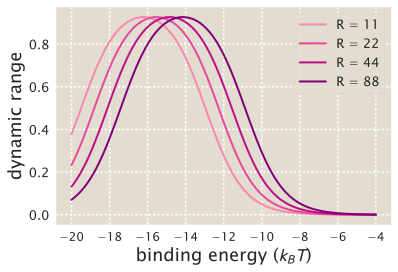

In [3]:
# Define parameters
energies = np.linspace(-20, -4, 100)
Reps = np.array([11, 22, 44, 88])

# Plot dynamic ranges
for R in Reps:
    plt.plot(energies, dynamic_range(energies, R), label=('R = %i' % R))

plt.xlabel(r'binding energy ($k_BT$)')    
plt.ylabel(r'dynamic range')
plt.legend()

As we can see from this plot, all values of $R$ have the same maximum dynamic range, but the maximum occurs at different values of $\Delta \varepsilon_R$. This makes sense, as the maximum dynamic range should occur at an identical value for $\frac{R}{N_{NS}} e^{-\Delta \varepsilon_R}$ for each strain, and changes in $R$ and $\Delta \varepsilon_R$ compensate one another. We can see from this plot that the maximum dynamic range for the wild type repressor copy number, $R=11$, occurs at approximately $-16.4~k_BT$. This is about $1~k_BT$ stronger than the natural operator O1. Moreover, a two-dimensional plot allows us to see more clearly how repressor copy number and $\Delta \varepsilon_R$ interact to determine dynamic range. 

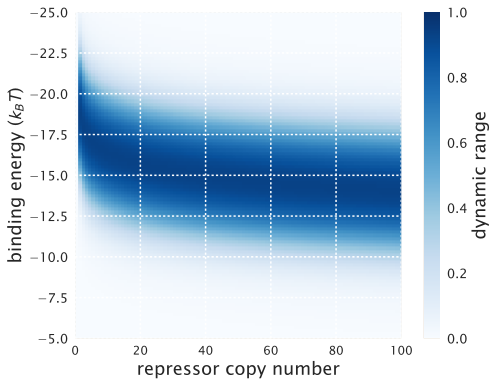

In [4]:
# Define ranges of binding energy and repressor copy number
fitness_map = np.zeros((100,100)) # Sets up grid for heat map
Reps = np.linspace(0,100,100)
energies = np.linspace(-25, -5, 100)

# fill heat map with dynamic range values
for i in range(100):
    for j in range(100):
        fitness_map[i, j] = dynamic_range(energies[i], Reps[j])

# Create plot
plt.figure(figsize=(8,6))
plt.imshow(fitness_map, cmap='Blues', extent=[0, 100, -5, -25], clim=[0.0, 1.0])
plt.colorbar(label='dynamic range')
plt.ylabel(r'binding energy ($k_BT$)')
plt.xlabel('repressor copy number')
axes = plt.gca()
axes.set_aspect(5)

Clearly, we should be able to solve for the maximum of the dynamic range equation and identify the ideal binding energy for each strain. I rewrite the equation for dynamic range in the form

\begin{equation}
\mathrm{dynamic\ range} = \left(1 + C_1 e^{-\Delta \varepsilon_R}\right)^{-1} - \left(1 + C_2 e^{-\Delta \varepsilon_R}\right)^{-1}
\end{equation}

where $C_1 = \frac{1}{1 + e^{-\Delta \varepsilon_{AI}}\left(\frac{K_A}{K_I}\right)^2} \frac{R}{N_{NS}}$ and $C_2 = \frac{1}{1 + e^{-\Delta \varepsilon_{AI}}} \frac{R}{N_{NS}}$. Then, the derivative of the dynamic range is equal to 

\begin{equation}
\frac{\partial}{\partial \varepsilon} = \varepsilon e^{-\varepsilon} \left(\frac{C_1}{\left(1 + C_1 e^{-\varepsilon}\right)^2} - \frac{C_2}{\left(1 + C_2 e^{-\varepsilon}\right)^2}\right),
\end{equation}

where for convenience I have written $\beta \Delta \varepsilon_R$ as simply $\varepsilon$. Setting the derivative equal to zero and then solving for $\varepsilon$ gives us $\Delta \varepsilon_\mathrm{R, ideal} = \frac{1}{2}\ln{C_1C_2}\ k_BT$. Substituting $C_1$ and $C_2$ back into the equation gives us

\begin{equation}
\Delta \varepsilon_\mathrm{R, ideal} = \frac{1}{2} \ln{\left[\left(\frac{R}{N_{NS}}\right)^2 \frac{1}{\left(1 + e^{-\beta \Delta \varepsilon_{AI}}\right)\left(1 + e^{-\beta \Delta \varepsilon_{AI}} \left(\frac{K_A}{K_I}\right)^2\right)}\right]}\ k_BT.
\end{equation}

This is plotted out below.

In [5]:
# Solve for ideal binding energy

def ideal_energy(R):
    '''
    Returns the binding energy that maximizes dynamic range for lac simple repression system.
    
    INPUTS
    ------
    R: float, number of repressors per cell
    
    OUTPUTS
    -------
    "Ideal" binding energy
    '''
    # Define variables for LacI
    e_AI = 4.5 # Free energy difference between active and inactive state; k_BT units
    K_A = 141 # Inducer dissociation constant for active repressor; uM units
    K_I = 0.56 # Inducer dissociation constant for inactive repressor; uM units
    NNS = 4.6E6 # Number of nonspecific sites in genome; unitless
    
    # Define equations for derivative of dynamic range
    C1 = R/(NNS*(1 + np.exp(-e_AI)*(K_A/K_I)**2))
    C2 = R/(NNS*(1 + np.exp(-e_AI)))
    
    return 0.5*np.log(C1*C2)

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log


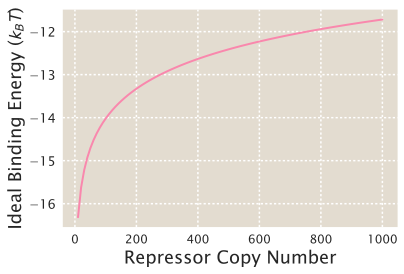

In [6]:
# Plot "ideal" binding energy as a function of repressor copy number
Reps_cont = np.linspace(0,1000,100) # Array of possible repressor copy numbers
plt.plot(Reps_cont, ideal_energy(Reps_cont))

plt.xlabel('Repressor Copy Number')
plt.ylabel(r'Ideal Binding Energy ($k_BT$)')